In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [83]:
exchange_data = pd.read_csv('GBPAUD_Daily.csv')
exchange_data.head()

,time,open,high,low,close,Volume,Volume MA
0,1975-01-01T22:00:00Z,1.7613,1.7613,1.7613,1.7613,0,NaN
1,1975-01-02T22:00:00Z,1.7682,1.7682,1.7682,1.7682,0,NaN
2,1975-01-05T22:00:00Z,1.7726,1.7726,1.7726,1.7726,0,NaN
3,1975-01-06T22:00:00Z,1.7706,1.7706,1.7706,1.7706,0,NaN
4,1975-01-07T22:00:00Z,1.7661,1.7661,1.7661,1.7661,0,NaN


/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_1301/978267006.py:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


Total data: 47 years
80 percent data = 2010 to 2047


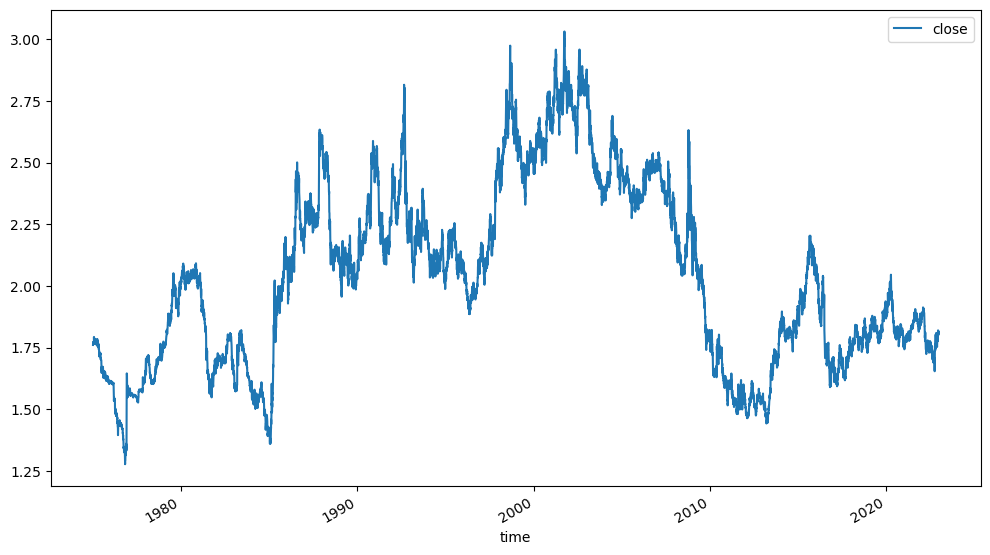

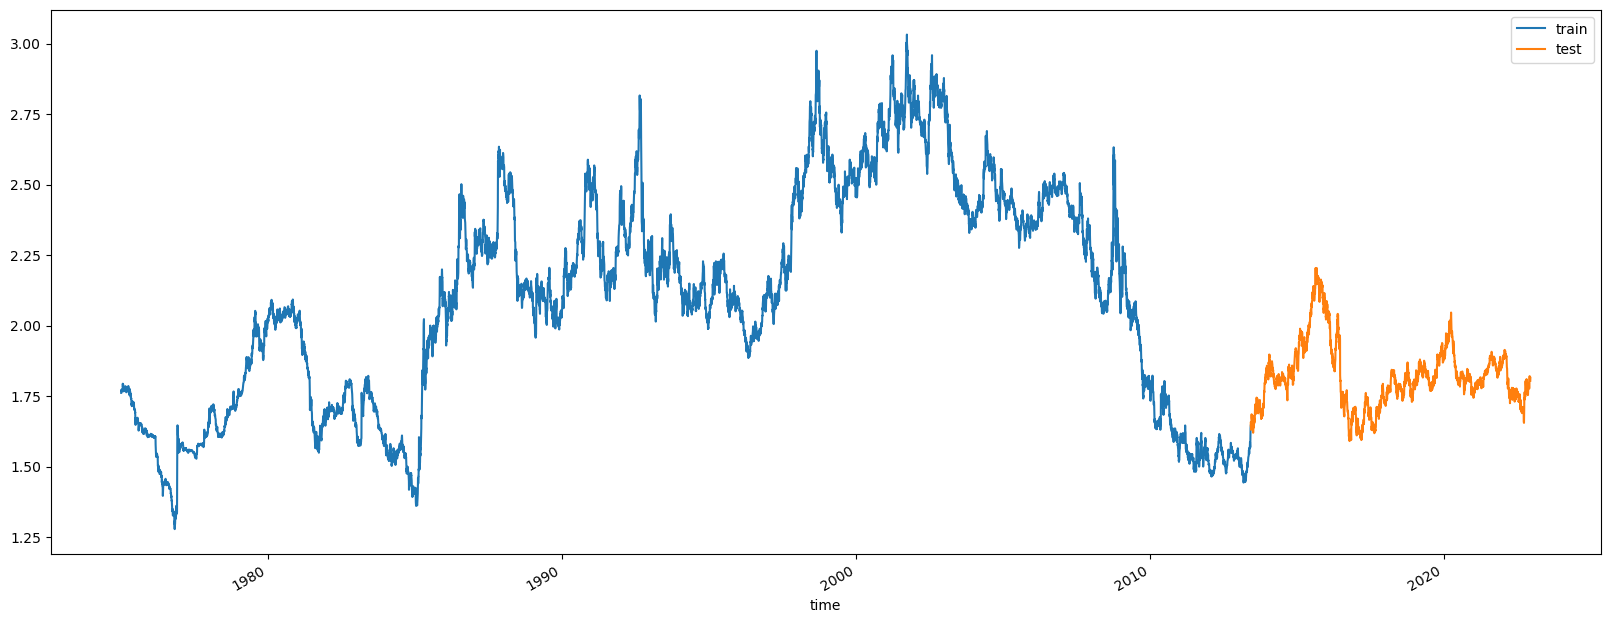

In [66]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)
ind_exchange_data.head()

data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('13-12-22')
data_frame = data_frame.loc[:cut_off_date]
clipped_length = len(data_frame)
data_frame.tail(10)

df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
split_length = int(x * 0.8)
#You need find the data where the training and testing will be split
split_date = data_frame.index[split_length]

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

X = []
y = []
timesteps = 6

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i, 0])
    Y_test_lstm.append(test_sc[i, 0])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))



In [67]:
def trainData():
    X = []
    y = []
    timesteps = 6

    for i in range(timesteps, train.shape[0]):
        X.append(train_sc[i-timesteps:i, 0])
        y.append(train_sc[i, 0])



    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [68]:
def testData():
    X_test_lstm = []
    Y_test_lstm = []

    for i in range(timesteps, test.shape[0]):
        X_test_lstm.append(test_sc[i-timesteps:i, 0])
        Y_test_lstm.append(test_sc[i, 0])


    X_test_lstm = np.array(X_test_lstm)
    Y_test_lstm = np.array(Y_test_lstm)
    X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
    
    

In [69]:
#all models

K.clear_session()

model_lstm_gru_cnn = tf.keras.Sequential([
    tf.keras.layers.LSTM(83, return_sequences=True, input_shape=(6, 1)),
    tf.keras.layers.GRU(190, return_sequences=True),
    tf.keras.layers.Conv1D(filters=76, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])

model_cnn_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=53, kernel_size=3, activation='relu', input_shape=(6, 1)),
    tf.keras.layers.Conv1D(filters=148, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])

model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])




model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))


model_lstm_gru= Sequential()
model_lstm_gru.add(LSTM(30, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm_gru.add(LSTM(32, activation='relu',return_sequences=True))
model_lstm_gru.add(LSTM(16, activation='relu',return_sequences=True))
model_lstm_gru.add(GRU(26,  activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm_gru.add(Dense(1))

In [70]:
model_lstm_gru_cnn.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm_gru_cnn = model_lstm_gru_cnn.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
52/52 [==============================] - 2s 15ms/step - loss: 0.1799 - rmse: 0.4242
Epoch 2/100
52/52 [==============================] - 1s 15ms/step - loss: 0.0726 - rmse: 0.2695
Epoch 3/100
52/52 [==============================] - 1s 19ms/step - loss: 0.0284 - rmse: 0.1686
Epoch 4/100
52/52 [==============================] - 1s 17ms/step - loss: 0.0227 - rmse: 0.1505
Epoch 5/100
52/52 [==============================] - 1s 16ms/step - loss: 0.0207 - rmse: 0.1439
Epoch 6/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0207 - rmse: 0.1438
Epoch 7/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0205 - rmse: 0.1431
Epoch 8/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0206 - rmse: 0.1435
Epoch 9/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0190 - rmse: 0.1379
Epoch 10/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0198 - rmse: 0.1407
Epoch 11/100
52/52 [===================

In [71]:
model_cnn_cnn.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_cnn_cnn = model_cnn_cnn.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2014 - rmse: 0.4488
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0076 - rmse: 0.0870
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0052 - rmse: 0.0723
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0053 - rmse: 0.0730
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0046 - rmse: 0.0679
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0116 - rmse: 0.1076
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0144 - rmse: 0.1199
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0076 - rmse: 0.0873
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0065 - rmse: 0.0805
Epoch 10/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0055 - rmse: 0.0745
Epoch 10: early stopping


In [72]:
model_cnn_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_cnn_lstm = model_cnn_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
52/52 [==============================] - 1s 2ms/step - loss: 0.4603 - rmse: 0.6785
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.0416 - rmse: 0.2041
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0177 - rmse: 0.1330
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0166 - rmse: 0.1287
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0160 - rmse: 0.1266
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0161 - rmse: 0.1269
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0175 - rmse: 0.1325
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0181 - rmse: 0.1345
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0192 - rmse: 0.1386
Epoch 10/100
52/52 [==============================] - 0s 2ms/step - loss: 0.0200 - rmse: 0.1415
Epoch 10: early stopping


In [73]:

model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
52/52 [==============================] - 2s 7ms/step - loss: 0.3674 - rmse: 0.6061
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0208 - rmse: 0.1443
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0117 - rmse: 0.1081
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0088 - rmse: 0.0938
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0087 - rmse: 0.0931
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0097 - rmse: 0.0984
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0142 - rmse: 0.1191
Epoch 8/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0273 - rmse: 0.1653
Epoch 9/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0157 - rmse: 0.1252
Epoch 10/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0083 - rmse: 0.0912
Epoch 11/100
52/52 [=============================

In [74]:
model_lstm_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm_gru = model_lstm_gru.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])





Epoch 1/100
52/52 [==============================] - 3s 7ms/step - loss: 0.9904 - rmse: 0.9952
Epoch 2/100
52/52 [==============================] - 0s 7ms/step - loss: 0.2671 - rmse: 0.5168
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 0.1336 - rmse: 0.3655
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0360 - rmse: 0.1899
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0084 - rmse: 0.0918
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0080 - rmse: 0.0897
Epoch 8/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0079 - rmse: 0.0887
Epoch 9/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0078 - rmse: 0.0881
Epoch 10/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0077 - rmse: 0.0876
Epoch 11/100
52/52 [=============================

In [75]:
#Model predictions 

y_pred_test_lstm1 = model_lstm_gru_cnn.predict(X_test_lstm)
y_pred_test_lstm2 = model_cnn_cnn.predict(X_test_lstm)
y_pred_test_lstm3 = model_cnn_lstm.predict(X_test_lstm)
y_pred_test_lstm4 = model_lstm.predict(X_test_lstm)
y_pred_test_lstm5 = model_lstm_gru.predict(X_test_lstm)



77/77 [==============================] - 0s 1ms/step


In [84]:
def futrePredictions(y_pred_test_lstm, model_lstm):
    last_prediction = y_pred_test_lstm[-timesteps:]
    last_prediction = np.array(last_prediction)

    for i in range(10):
        next_input = np.array([last_prediction[-timesteps:]])
        next_input = next_input.reshape((next_input.shape[0], next_input.shape[1], 1))
        #add all models
        next_prediction = model_lstm.predict(next_input, verbose=0)
        last_prediction = np.append(last_prediction, next_prediction[0])


    lstm_future = np.array(last_prediction[-10:]).reshape(-1,1)
    inverse_transformed_data_lstm = sc.inverse_transform(lstm_future).flatten().tolist()
    lstm_rounded_numbers = [round(x, 5) for x in inverse_transformed_data_lstm]
    future_lstm_prices = []
    last_lstm = sc.inverse_transform(y_pred_test_lstm[-1:])
    future_lstm_prices.append(round(float(last_lstm[0]),5))
    for x in lstm_rounded_numbers:
        future_lstm_prices.append(x) 
    
    return future_lstm_prices








    

In [85]:

future_comparison = ind_exchange_data.iloc[clipped_length-1:]

future = future_comparison.iloc[0:11]

future_prices_table = future["close"]

future_prices = []
for x in future_prices_table:
    future_prices.append(x)



In [86]:
future_lstm_prices1 = futrePredictions(y_pred_test_lstm1,model_lstm_gru_cnn)
future_lstm_prices2 = futrePredictions(y_pred_test_lstm2,model_cnn_cnn)
future_lstm_prices3 = futrePredictions(y_pred_test_lstm3,model_cnn_lstm)
future_lstm_prices4 = futrePredictions(y_pred_test_lstm4,model_lstm)
future_lstm_prices5 = futrePredictions(y_pred_test_lstm5,model_lstm_gru)

In [96]:

def classify_numbers(lst):
    classifications = []
    prev_num = lst[0]
    for i, num in enumerate(lst[1:], start=1):
        if num > prev_num:
            classifications.append('green')
        else:
            classifications.append('red')
        prev_num = num
    return classifications




In [97]:
def drawgraph(future_lstm_prices, text):
    classifications2 = classify_numbers(future_lstm_prices)

    fig, ax2 = plt.subplots(1, 1, figsize=(8, 2))

    ax2.plot(future_lstm_prices, color='blue')
    for i, c in enumerate(classifications2):
        if c == 'green':
            ax2.axvspan(i, i+1, facecolor='green', alpha=0.2)
        elif c == 'red':
            ax2.axvspan(i, i+1, facecolor='red', alpha=0.2)
    ax2.set_title(text)
    plt.subplots_adjust(hspace=0.5)
    plt.show()


    

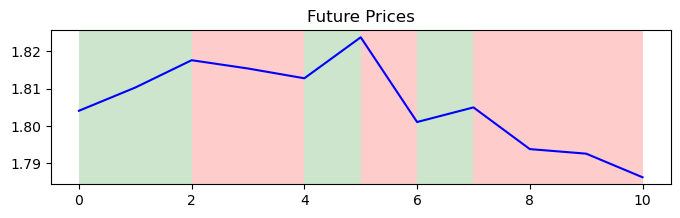

In [98]:
classifications2 = classify_numbers(future_prices)

fig, ax2 = plt.subplots(1, 1, figsize=(8, 2))

ax2.plot(future_prices, color='blue')
for i, c in enumerate(classifications2):
    if c == 'green':
        ax2.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax2.axvspan(i, i+1, facecolor='red', alpha=0.2)
ax2.set_title('Future Prices')
plt.subplots_adjust(hspace=0.5)
plt.show()


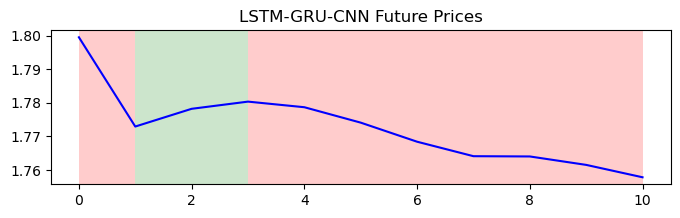

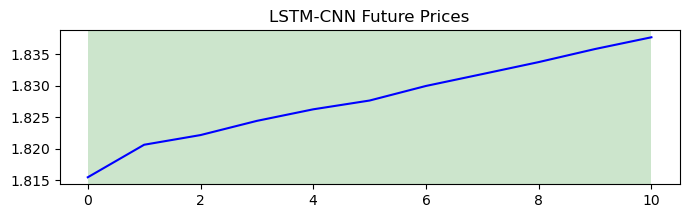

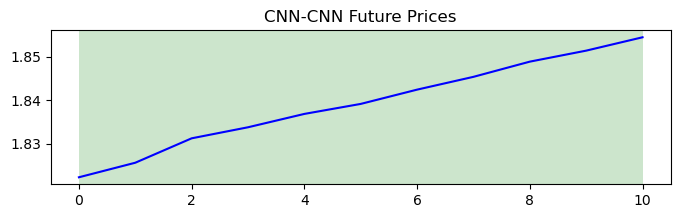

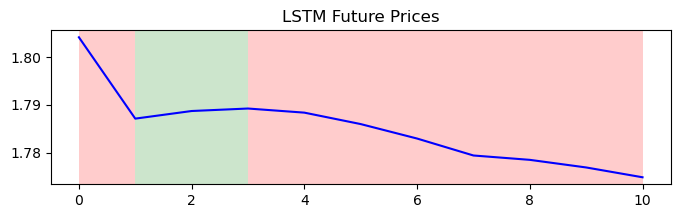

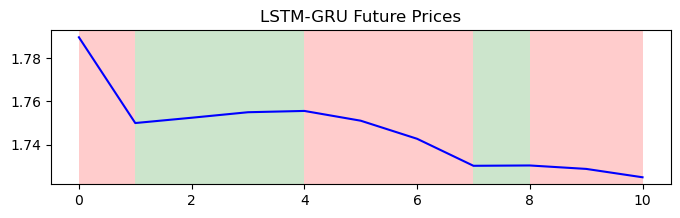

In [99]:
drawgraph(future_lstm_prices1, "LSTM-GRU-CNN Future Prices")
drawgraph(future_lstm_prices2, "LSTM-CNN Future Prices")
drawgraph(future_lstm_prices3, "CNN-CNN Future Prices")
drawgraph(future_lstm_prices4, "LSTM Future Prices")
drawgraph(future_lstm_prices5, "LSTM-GRU Future Prices")